# Detection and Classification of Ultrasonic Vocalizations (USVs) in Rodent Audio Data

In this notebook, we will demonstrate how to **detect** and **classify** ultrasonic vocalizations (USVs) in rodent audio recordings using spectrogram analysis, Geodesic Active Contours (GAC) for segmentation, and a Convolutional Neural Network (CNN) for classification.

## Overview

- **Load Audio Data**: Start by loading an audio file containing rodent vocalizations.
- **Generate Spectrogram**: Create a spectrogram of a selected segment of the audio data to visualize the frequency content over time.
- **Detect USVs**: Use Geodesic Active Contours (GAC) to detect potential USVs in the spectrogram.
- **Classify USVs**: Classify the detected USVs using a pre-trained CNN model to distinguish between different types of vocalizations.

## Importing Libraries

We begin by importing the necessary libraries:

- **torchaudio**: For loading and processing audio data.
- **matplotlib**: For plotting and visualizing data.
- **mouse.utils**, **mouse.segmentation**: Custom modules for sound utilities, segmentation, and classification specific to mouse USVs.
- **pathlib**: For handling file paths and operating system interactions.
- **typing**, **functools**, **copy**, **tqdm**: For type annotations, function tools, copying objects, and progress bars.


In [40]:
import torchaudio
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mouse.utils import sound_util, data_util
from mouse.segmentation import segmentation, GAC
from pathlib import Path
from tqdm import tqdm
import numpy as np

## Loading the Audio File
We will load the audio file containing the rodent vocalizations.

## Note
Please ensure that the audio file is present in your working directory. We will also create a `SignalData` object from the audio file.

In [41]:
file_path = Path(r"long-example-rodent.wav")
waveform, sample_rate = torchaudio.load(file_path)
signal_data = sound_util.SignalData(file_path)
signal_data

name: long-example-rodent.wav, length: 9.8863 [s]

## Generating the Spectrogram

Next, we will generate a spectrogram of the audio data to visualize its frequency content over time.

### Parameters

**Parameters:**

- `signal_data` (*sound_util.SignalData*): The signal data containing the waveform and sample rate.
- `n_fft` (*int*, optional): The size of FFT, creates `n_fft // 2 + 1` bins. Default is `400`.
- `win_length` (*int*, optional): Window size. Default is `n_fft`.
- `hop_length` (*int*, optional): Length of hop between STFT windows. Default is `win_length // 2`.
- `power` (*float*, optional): Exponent for the magnitude spectrogram. Default is `2.0`.
- `center` (*bool*, optional): Whether to pad the input on both sides so that the `t`-th frame is centered at time `t * hop_length`. Default is `True`.
- `pad_mode` (*str*, optional): Controls the padding method used when `center` is `True`. Default is `'reflect'`.
- `t_start` (*float*, optional): The start time (in seconds) for the spectrogram.
- `t_end` (*float*, optional): The end time (in seconds) for the spectrogram.

In [42]:
# Parameters for spectrogram
n_fft = 400
win_length = n_fft
hop_length = win_length // 2
power = 2.0

# Create a spectrogram transform
spectrogram_transform = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode='reflect',
    power=power
)

# Compute the spectrogram for the whole signal
spec_data = sound_util.spectrogram(
    signal_data.signal,
    sample_rate=signal_data.sample_rate,
    spec_calculator=spectrogram_transform,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=power
)

# Clip the spectrogram to the selected time window
spec_data = sound_util.clip_spectrogram(
    spec_data,
    t_start=6.4,  # Start time in seconds,
    t_end=7  # End time in seconds
)

### Visualizing the Spectrogram

We will generate the spectrogram for a specific time window.


Text(0.5, 1.0, 'Spectrogram with Logarithmic Scaling')

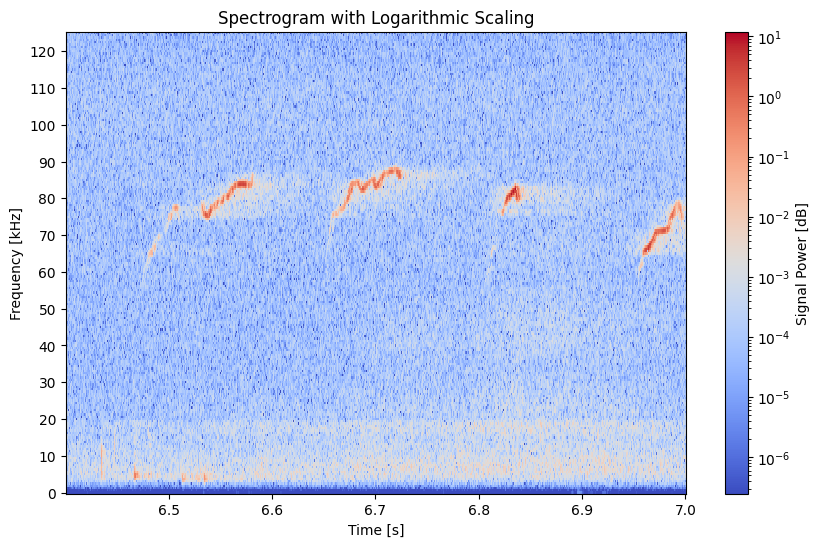

In [43]:
# Calculate the minimum and maximum values for LogNorm scaling
vmin = 10 ** (np.quantile(np.log10(spec_data.spec.flatten()), 0.01))  # 1st percentile of log-scaled data
vmax = spec_data.spec.max()  # Maximum value of the spectrogram

# Create the figure and axis for the spectrogram
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the spectrogram with logarithmic scaling for the color intensity
cax = ax.pcolormesh(
    spec_data.times,          
    spec_data.freqs / 1e3,    
    spec_data.spec,           
    cmap='coolwarm',          
    norm=LogNorm(vmin=vmin, vmax=vmax),  
)

# Set major ticks for x-axis (time) and y-axis (frequency)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1)) 
ax.yaxis.set_major_locator(plt.MultipleLocator(10))  

# Add a colorbar to indicate signal intensity
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label("Signal Power [dB]")  

# Add labels for the axes
ax.set_xlabel("Time [s]")            
ax.set_ylabel("Frequency [kHz]")    

# Add a title to the plot
ax.set_title("Spectrogram with Logarithmic Scaling")

## Detecting USVs Using Geodesic Active Contours (GAC)

We will use the Geodesic Active Contour (GAC) method to detect USVs in the spectrogram. This method allows us to segment the spectrogram and find regions that correspond to USVs.

### Parameters

**Parameters:**

- `spec` (*sound_util.SpectrogramData*): The spectrogram data to search for USVs.
- `min_side_length` (*int*): Minimum side length for bounding boxes.
- `level_set`: Used for generating the initial level set based on preprocessed `spec`.
- `gac_parameters`: Additional arguments passed to `morphological_geodesic_active_contour` from `skimage.segmentation`.


In [44]:
# Preprocess the spectrogram
_spec = segmentation.inverse_gaussian_gradient(spec_data.spec.numpy(), sigma=5, alpha=100)

# Initialize the level set
level_set_init = GAC.ones_level_set(_spec)

# Detect USVs using GAC
gac_parameters = {
    "num_iter": 230,
    "smoothing": 0,
    "threshold": 0.9,
    "balloon": -1
}  # Additional arguments for GAC

# Run the GAC algorithm with a progress bar
with tqdm(total=gac_parameters.get("num_iter", 100)) as pbar:
    gac_parameters['iter_callback'] = lambda _: pbar.update(1)
    gac_parameters.pop('iterations', None)  

    # Execute the GAC algorithm
    level_set_result = segmentation.morphological_geodesic_active_contour(
        _spec, init_level_set=level_set_init, **gac_parameters
    )


# Find bounding boxes for the detected regions
boxes = data_util.find_bounding_boxes(level_set_result,
                                      min_side_length=1)

# Filter the bounding boxes if required
detected_squeaks = data_util.filter_boxes(spec_data, boxes)

231it [00:00, 487.10it/s]                         


### Visualizing the Detected USVs

We will now visualize the detected USVs by plotting bounding boxes over the spectrogram.

Text(0.5, 1.0, 'Spectrogram with Logarithmic Scaling')

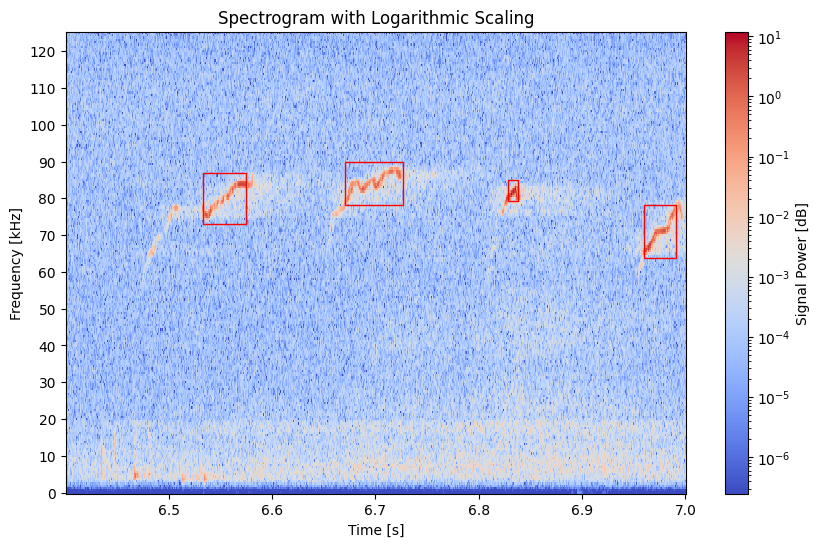

In [45]:
# Create the figure and axis for the spectrogram
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the spectrogram with logarithmic scaling for the color intensity
cax = ax.pcolormesh(
    spec_data.times,         
    spec_data.freqs / 1e3,   
    spec_data.spec,           
    cmap='coolwarm',          
    norm=LogNorm(vmin=vmin, vmax=vmax), 
)


# Set major ticks for x-axis (time) and y-axis (frequency)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))  
ax.yaxis.set_major_locator(plt.MultipleLocator(10))   

# Add a colorbar to indicate signal intensity
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label("Signal Power [dB]")  

for squeak_box in detected_squeaks:
    # Conversion of indexes to time and frequency values 
    # (GAC algorithm's output are indexes, not the values)
    t_start_idx = squeak_box.t_start
    t_end_idx = squeak_box.t_end
    f_start_idx = squeak_box.freq_start
    f_end_idx = squeak_box.freq_end
    
    # spec_data.times and spec_data.freqs are 1D arrays whose lengths correspond to the spectrogram dimensions
    t_start_val = spec_data.times[t_start_idx]
    t_end_val = spec_data.times[t_end_idx]
    f_start_val = spec_data.freqs[f_start_idx] / 1e3  # conversion to kHz
    f_end_val = spec_data.freqs[f_end_idx] / 1e3
    
    rect = plt.Rectangle(
        (t_start_val, f_start_val),
        t_end_val - t_start_val,
        f_end_val - f_start_val,
        linewidth=1,
        edgecolor='r',  # Red color for bounding boxes
        facecolor='none'
    )
    ax.add_patch(rect)

# Add labels for the axes
ax.set_xlabel("Time [s]")           
ax.set_ylabel("Frequency [kHz]")    

# Add a title to the plot
ax.set_title("Spectrogram with Logarithmic Scaling")

## Classifying Detected USVs Using Simple Thresholding

After detecting the USVs, we will classify them using a simple frequency-based thresholding method to determine whether they are high-frequency or low-frequency vocalizations.

### Parameters

**Parameters:**

- `spec` (*sound_util.SpectrogramData*): A spectrogram from which `squeak_boxes` come from.
- `squeak_boxes` (*List[SqueakBox]*): List of `SqueakBox` objects representing detected USVs.
- `threshold` (*Union[int, float]*): Frequency threshold (in kHz) that divides USVs into high and low frequency.
- `low_label` (*str*): Label to assign to low-frequency USVs.
- `high_label` (*str*): Label to assign to high-frequency USVs.

In [46]:
# Classify the detected USVs
spec = spec_data
squeak_boxes = detected_squeaks
threshold_frequency = 50.0 # in kHz
low_label = 'low freq'
high_label = 'high freq'

# Convert the frequency threshold to pixel units 
threshold_pixels = spec.freq_to_pixels(threshold_frequency)

# Classify each squeak box
classified_squeaks = []
for squeak_box in squeak_boxes:
    mean_freq = (squeak_box.freq_end + squeak_box.freq_start) / 2
    if mean_freq > threshold_pixels:
        squeak_box.label = high_label
    else:
        squeak_box.label = low_label
    classified_squeaks.append(squeak_box)

### Visualizing the Classified USVs

We will visualize the classified USVs by plotting bounding boxes with different colors based on their classification.

Text(0.5, 1.0, 'Spectrogram with Logarithmic Scaling')

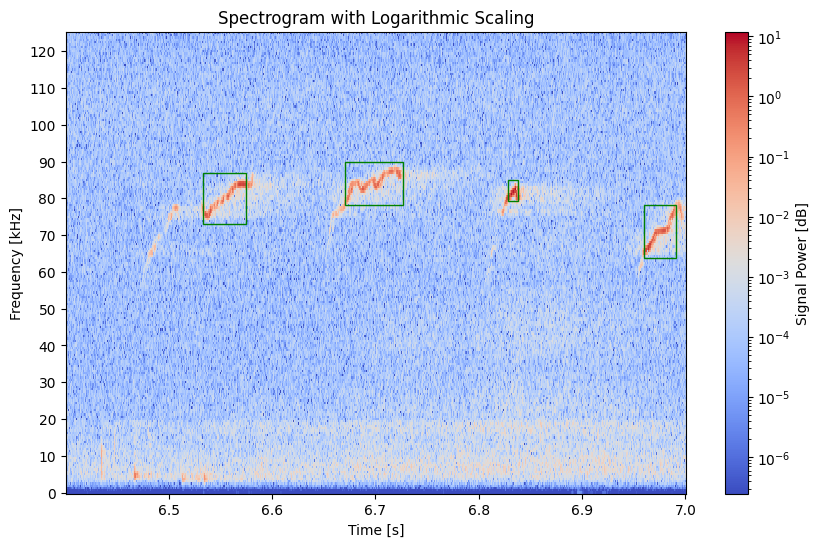

In [47]:
# Create the figure and axis for the spectrogram
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the spectrogram with logarithmic scaling for the color intensity
cax = ax.pcolormesh(
    spec_data.times,         
    spec_data.freqs / 1e3,   
    spec_data.spec,          
    cmap='coolwarm',         
    norm=LogNorm(vmin=vmin, vmax=vmax),  
)

# Set major ticks for x-axis (time) and y-axis (frequency)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1)) 
ax.yaxis.set_major_locator(plt.MultipleLocator(10))   

# Add a colorbar to indicate signal intensity
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label("Signal Power [dB]") 
    
for squeak_box in detected_squeaks:
    # Conversion of indexes to time and frequency values
    t_start_idx = squeak_box.t_start
    t_end_idx = squeak_box.t_end
    f_start_idx = squeak_box.freq_start
    f_end_idx = squeak_box.freq_end
    
    color = 'g' if squeak_box.label == "high freq" else 'r' # Green for 'high freq', red for 'low freq'
    
    # spec_data.times and spec_data.freqs are 1D arrays whose lengths correspond to the spectrogram dimensions
    t_start_val = spec_data.times[t_start_idx]
    t_end_val = spec_data.times[t_end_idx]
    f_start_val = spec_data.freqs[f_start_idx] / 1e3  # conversion to kHz
    f_end_val = spec_data.freqs[f_end_idx] / 1e3
    
    rect = plt.Rectangle(
        (t_start_val, f_start_val),
        t_end_val - t_start_val,
        f_end_val - f_start_val,
        linewidth=1,
        edgecolor=color,
        facecolor='none'
    )
    ax.add_patch(rect)

# Add labels for the axes
ax.set_xlabel("Time [s]")            
ax.set_ylabel("Frequency [kHz]")    

# Add a title to the plot
ax.set_title("Spectrogram with Logarithmic Scaling")

## Conclusion

In this notebook, we demonstrated how to detect and classify ultrasonic vocalizations (USVs) in rodent audio recordings using a simple frequency-based thresholding method. We:

- Loaded and visualized the audio data using spectrograms.
- Detected USVs using Geodesic Active Contours (GAC).
- Classified the detected USVs based on a frequency threshold.
- Visualized the results by plotting bounding boxes over the spectrogram.

This approach provides a straightforward method for analyzing rodent vocalizations and can be useful in research settings where quick classification is needed.